# Assignment 1: MLPs and Backpropagation
### <font color='blue'> Due on November 9th, 2025 (23:59:59) </font>

Welcome to Comp541: Deep Learning Course!

Before you start, make sure you read the README.txt in the same directory as this notebook for important setup information. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning.

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/merterdem/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://towardsdatascience.com/word-vectors-intuition-and-co-occurence-matrixes-a7f67cae16cd/)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [2]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [4]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1

    # ------------------
    # Write your implementation here.
    corpus_words = sorted({word for sentence in corpus for word in sentence})
    num_corpus_words = len(corpus_words)    
    # ------------------

    return corpus_words, num_corpus_words

In [5]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors.


In [6]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}

    # ------------------
    # Write your implementation here.
    M = np.zeros((num_words, num_words))
    word2ind = {w: i for i, w in enumerate(words)}

    for sentence in corpus:
        for i, w in enumerate(sentence):
            start, end = max(0, i - window_size), min(len(sentence), i + window_size + 1)
            for j in range(start, end):
                if i != j:
                    M[word2ind[w], word2ind[sentence[j]]] += 1
    # ------------------

    return M, word2ind

In [7]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [8]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Write your implementation here.
    
    M_reduced = TruncatedSVD(n_components=k, n_iter=n_iters).fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [9]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [10]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
        index = word2ind[word]
        x = M_reduced[index, 0]
        y = M_reduced[index, 1]
        plt.scatter(x, y, marker = 'x', color = 'red')
        plt.text(x, y, word)
    plt.show()
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


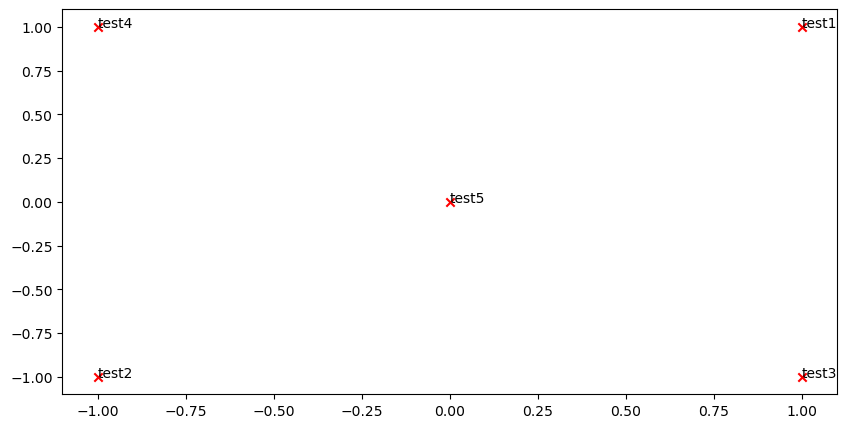

--------------------------------------------------------------------------------


In [11]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


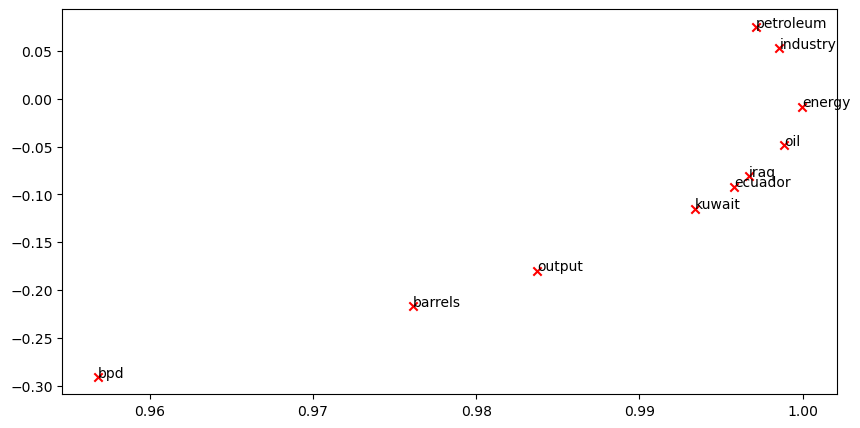

In [12]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>
Cluster 1: petroleum, industry, energy, oil, iraq, ecuador, kuwait
Cluster 2: barrels, output
Cluster 3: bpd
in my opinion “bpd” should cluster with “barrels” since it means barrels per day. Its separation probably occurs because it’s a technical term so it's used less.

## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [13]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [14]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [15]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [16]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

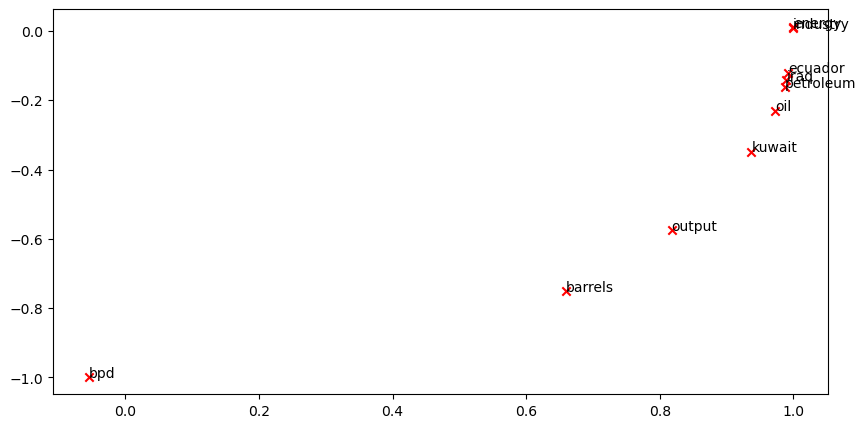

In [17]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

<font color="red">Write your answer here.</font>
* What clusters together in 2-dimensional embedding space?
* Cluster 1: bpd
* Cluster 2: barrels, output, kuwait
* Cluster 3: oil, petroleum, ecuador, iraq
* Cluster 4: industry, energy

##  What doesn’t cluster together that you think should have?
bpd should cluster with barrels since it represents “barrels per day.” The separation likely occurs because bpd is a technical term often used in the context of rates or production flow, while barrels is generally used for quantities or storage.

## How is the plot different from the one generated earlier from the co-occurrence matrix?

It is very similar to co-occure matrix, but in glove the words that were originally close to each other even form tighter clusters. Such as industry and energy.

## What might cause this difference?

I didn't read the GloVe paper, but it is obvious that some sort of co-occurence count is used in glove, so that might explain the similarity, but again GloVe is prediction based, therefore it might capture richer relationships between the words.

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written]
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [19]:
# ------------------
# Write your implementation here.
print("Top 10 similar words to 'bank':")
for w, s in wv_from_bin.most_similar("bank", topn=10):
    print(f"{w}: {s:.4f}")
# ------------------


Top 10 similar words to 'bank':
banks: 0.7626
banking: 0.6819
central: 0.6284
financial: 0.6167
credit: 0.6050
lending: 0.5981
monetary: 0.5963
bankers: 0.5913
loans: 0.5803
investment: 0.5740


#### <font color="red">Write your answer here.</font>

The word **bank** is strongly polysemous, but the top-10 cosine neighbors all are about the financial institution meaning; none reference the riverbank or sitting sense.

That happens because the training corpus overwhelmingly uses *bank* in economic contexts, so the learned vector is dominated by that usage.


### Question 2.3: Synonyms & Antonyms (2 points) [code + written]

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$.

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [23]:
# ------------------
# Write your implementation here.
word = "black"
synonym = "dark"
antonym = "white"

syn_dist = wv_from_bin.distance(word, synonym)
ant_dist = wv_from_bin.distance(word, antonym)

print(f"Base word: {word}")
print(f"Synonym: {synonym}")
print(f"Antonym: {antonym}\n")

print(f"Cosine distance ({word}, {synonym}): {syn_dist:.4f}")
print(f"Cosine distance ({word}, {antonym}): {ant_dist:.4f}")

print(f"\nIs the antonym closer? {ant_dist < syn_dist}")

# ------------------

Base word: black
Synonym: dark
Antonym: white

Cosine distance (black, dark): 0.3461
Cosine distance (black, white): 0.2070

Is the antonym closer? True


#### <font color="red">Write your answer here.</font>
Antonyms might be used the word a lot more, for instance think about he word black and white, it kinda makes sense for the word 'black' to be used a lot more with 'white' rather than 'dark'. 

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [26]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


Let $m$, $k$, $w$, and $x$ denote the word vectors for `man`, `king`, `woman`, and the answer, respectively. Using **only** vectors $m$, $k$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `king` and the answer?

#### <font color="red">Write your answer here.</font>
**Maximizing cosine similarity**: x = k - m + w

On a coordinate plane, man and woman would appear on opposite sides of the gender axis, while king and its counterpart queen would be positioned above them along the royalty axis.


### Question 2.5: Finding Analogies [code + written]  (1.5 points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [38]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['yacht', 'wheel'], negative=['car']))

# ------------------

[('sails', 0.5503749847412109),
 ('paddle', 0.5394437909126282),
 ('sailboat', 0.5386458039283752),
 ('yachts', 0.5321522355079651),
 ('sail', 0.5257940292358398),
 ('sailing', 0.5093687176704407),
 ('sloop', 0.4893396496772766),
 ('catamaran', 0.47028568387031555),
 ('ship', 0.4548482596874237),
 ('boat', 0.44671985507011414)]


#### <font color="red">Write your answer here.</font>

* Analogy: car : yacht :: wheel : sails

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [42]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['archer', 'sword'], negative=['warrior']))

# ------------------

[('daniels', 0.4717496335506439),
 ('thompson', 0.3989226222038269),
 ('bradbury', 0.36467820405960083),
 ('blades', 0.35611820220947266),
 ('hilt', 0.3544963598251343),
 ('jack', 0.3534688949584961),
 ('rowland', 0.3467264175415039),
 ('paulson', 0.34564343094825745),
 ('kazarian', 0.34124884009361267),
 ('mich.', 0.3411330580711365)]


#### <font color="red">Write your answer here.</font>

*Intended analogy:
* warrior : sword :: archer : bow

got a lot of names instead

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [29]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.606891930103302),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321308970451355),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108282089233),
 ('working', 0.5615329146385193),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278827548027039),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054521560668945),
 ('factory', 0.4940453767776489)]


#### <font color="red">Write your answer here.</font>

* Words associated with females include terms like "nurse", "pregnant", and "homemaker", which are primarily linked to caregiving roles. 

* In contrast, male-associated words such as "mechanic", "factory", and "engineer" are related to technical and industrial occupations.


### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [43]:
# ------------------
# Write your implementation here.

pprint.pprint(wv_from_bin.most_similar(positive=['doctor', 'woman'], negative=['man']))

pprint.pprint(wv_from_bin.most_similar(positive=['doctor', 'man'], negative=['woman']))

# ------------------

[('nurse', 0.6813318729400635),
 ('physician', 0.6672453284263611),
 ('doctors', 0.6173422336578369),
 ('dentist', 0.5775880813598633),
 ('surgeon', 0.5691418647766113),
 ('hospital', 0.564996600151062),
 ('pregnant', 0.5649075508117676),
 ('nurses', 0.5590691566467285),
 ('medical', 0.5542058944702148),
 ('patient', 0.5518485307693481)]
[('dr.', 0.548629641532898),
 ('physician', 0.5327188968658447),
 ('he', 0.5275285243988037),
 ('him', 0.5230658054351807),
 ('himself', 0.5116503238677979),
 ('medical', 0.5046803951263428),
 ('his', 0.5044265985488892),
 ('brother', 0.503484845161438),
 ('surgeon', 0.5005415678024292),
 ('mr.', 0.4938008487224579)]


#### <font color="red">Write your answer here.</font>

In this example, when combining "doctor" with "woman", the model may return words related to caregiving or nursing professions. (Dentist, nurse)

while combining "doctor" with "man" tends to yield results linked to authority or higher-status medical positions. (Physician, surgeon).


### Question 2.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

#### <font color="red">Write your answer here.</font>

**How bias appears:** Word vectors mirror the statistics of the text they were trained on. If the corpus more often links certain groups with particular roles or attributes, those associations will be in the embeddings.

**Experiment:** Choose a list of occupations (e.g., engineer, nurse, teacher) and measure their cosine similarity to `man` versus `woman`. Consistent skew toward one gender would show the bias coming from the corpus.


## Part 3: Sentiment Analysis (15 points)

Lastly, you will implement a simple sentiment classifier **from scratch** by using the Deep Averaging Network (DAN) proposed in the [paper](https://aclanthology.org/P15-1162.pdf). The model is based on the following three steps:

- Take the vector average of the embeddings associated with the words in the inputs
- Pass that average vector through one or more feed-forward layers
- Perform linear classification on the final layer’s representation


Here, you will use Stanford Sentiment Treebank (SST) dataset but note that in this dataset, the sentiment levels are originally represented with real values. Hence, you need to discretize these values into the following five classes:


- 0: "very negative" ($\le 0.2$),
- 1: "negative" ($\le 0.4$),
- 2: "neutral" ($\le 0.6$),
- 3: "positive" ($\le 0.8$),
- 4: "very positive" ($>$ 0.8)


### Download the Dataset
You can download the dataset [here](https://nlp.stanford.edu/sentiment/) (Download the "**Main zip file with readme (6mb)**" version). Please read `README.txt` in details, that comes with the .zip folder.

**Create a /data directory to store your SST data and unzip your downloaded folder there.** Your data path should be like following:

```
./comp541-441/assignment1/data
                            └── stanfordSentimentTreebank
                                ├── README.txt
                                ├── SOStr.txt
                                ├── STree.txt
                                ├── datasetSentences.txt
                                ├── datasetSplit.txt
                                ├── dictionary.txt
                                ├── original_rt_snippets.txt
                                └── sentiment_labels.txt
```

Or, you can simply use Huggingface's **datasets** library if you are familiar.

### What to show
In your work, perform the following experiments and explain your findings:

- Provide your loss curves by plotting them clearly,
- Play with the number of layers,
- Try with embeddings trained on different corpuses
- Test with the GloVe embeddings and the embeddings formed through the word co-occurrence matrix. Report your results on the test set for both types of embeddings (make sure to use the same test set for both, to ensure a fair comparison).

In [44]:
print("M_reduced_co_occurrence shape:", M_reduced_co_occurrence.shape)  # Should be (num_words, 2)
print("word2ind_co_occurrence length:", len(word2ind_co_occurrence))
print(M.shape)

M_reduced_co_occurrence shape: (8185, 2)
word2ind_co_occurrence length: 8185
(10010, 200)


In [46]:
# ------------------
# Start your implementation here.
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import torch.nn as nn
from torch import optim
from typing import Tuple, List, Counter, Dict


data = load_dataset("stanfordnlp/sst", trust_remote_code=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# ------------------


Using device: cpu


In [55]:
def prepare_sentence_embeddings_from_matrix(tokens_list, labels, embedding_matrix, word2ind):
    """Average the embeddings (rows of embedding_matrix) for each sentence."""
    sentence_embeddings = []
    dim = embedding_matrix.shape[1]

    for tokens, label in zip(tokens_list, labels):
        word_vectors = [embedding_matrix[word2ind[tok]] for tok in tokens if tok in word2ind]
        if not word_vectors:
            continue
        sent_vec = np.mean(word_vectors, axis=0)
        sentence_embeddings.append((sent_vec, label))

    return sentence_embeddings


def prepare_sentence_embeddings_from_glove(tokens_list, labels, keyed_vectors):
    """Average GloVe embeddings for each sentence, skipping OOV tokens."""
    sentence_embeddings = []
    dim = keyed_vectors.vector_size

    for tokens, label in zip(tokens_list, labels):
        word_vectors = []
        for tok in tokens:
            try:
                word_vectors.append(keyed_vectors[tok])
            except KeyError:
                continue
        if not word_vectors:
            continue
        sent_vec = np.mean(word_vectors, axis=0)
        sentence_embeddings.append((sent_vec, label))

    return sentence_embeddings


In [56]:
# Helper to tokenize a list of sentences
def tokenize_split_alpha(sentences):
    """Split sentences on '|' and keep only alphabetic, lower-cased tokens."""
    tokenized = []
    for s in sentences:
        tokens = [tok.lower() for tok in s.split('|') if tok.isalpha()]
        tokenized.append(tokens)
    return tokenized


# Helper to map continuous labels in [0,1] to 0–4
def to_discrete_labels(raw_labels):
    """
    Convert original labels to 5-point discrete scale [0..4].
    Steps:
    - scale by 5
    - round to nearest integer
    - clip to [1,5]
    - shift to [0,4]
    """
    raw_arr = np.array(raw_labels) * 5
    rounded = np.round(raw_arr)
    clipped = np.clip(rounded, 1, 5).astype(int)
    return (clipped - 1).tolist()


# Tokenize each split and map labels
def preprocess_split(split_name):
    return tokenize_split_alpha(data[split_name]["tokens"]), to_discrete_labels(data[split_name]["label"])


train_tokens_list, train_labels = preprocess_split("train")
validation_tokens_list, validation_labels = preprocess_split("validation")
test_tokens_list, test_labels = preprocess_split("test")

# ----- Build co-occurrence embeddings -----
CO_OCC_WINDOW = 4
CO_OCC_DIM = 100

coocc_matrix, coocc_word2ind = compute_co_occurrence_matrix(train_tokens_list, window_size=CO_OCC_WINDOW)
coocc_embeddings = reduce_to_k_dim(coocc_matrix, k=CO_OCC_DIM)

coocc_train = prepare_sentence_embeddings_from_matrix(train_tokens_list, train_labels, coocc_embeddings, coocc_word2ind)
coocc_val = prepare_sentence_embeddings_from_matrix(validation_tokens_list, validation_labels, coocc_embeddings, coocc_word2ind)
coocc_test = prepare_sentence_embeddings_from_matrix(test_tokens_list, test_labels, coocc_embeddings, coocc_word2ind)

# ----- Build GloVe embeddings -----
glove_train = prepare_sentence_embeddings_from_glove(train_tokens_list, train_labels, wv_from_bin)
glove_val = prepare_sentence_embeddings_from_glove(validation_tokens_list, validation_labels, wv_from_bin)
glove_test = prepare_sentence_embeddings_from_glove(test_tokens_list, test_labels, wv_from_bin)

experiments = {
    "Co-occurrence (k=100)": {
        "train": coocc_train,
        "val": coocc_val,
        "test": coocc_test,
        "input_dim": coocc_embeddings.shape[1],
    },
    "GloVe (200d)": {
        "train": glove_train,
        "val": glove_val,
        "test": glove_test,
        "input_dim": wv_from_bin.vector_size,
    },
}

print("Sentences kept per experiment:", {name: len(cfg["train"]) for name, cfg in experiments.items()})


Running Truncated SVD over 14702 words...
Done.
Sentences kept per experiment: {'Co-occurrence (k=100)': 8535, 'GloVe (200d)': 8535}


In [57]:
batch_size = 256
num_epochs = 50
hidden_size = 64
num_classes = 5
learning_rate = 0.001


In [58]:
def build_loader(pairs, batch_size, shuffle):
    """
    Convert (embedding, label) pairs to tensors
    and wrap them in a DataLoader.
    """
    if not pairs:
        raise ValueError("No sentence embeddings available to build a DataLoader.")

    emb_list, label_list = zip(*pairs)
    emb_tensor = torch.as_tensor(emb_list, dtype=torch.float32)
    label_tensor = torch.as_tensor(label_list, dtype=torch.long)

    dataset = TensorDataset(emb_tensor, label_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [59]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # First linear layer + nonlinearity
        hidden = self.fc1(x)
        hidden = self.activation(hidden)

        # Output layer (logits for each class)
        out = self.fc2(hidden)
        return out


In [60]:
criterion = nn.CrossEntropyLoss()


In [61]:
def evaluate_accuracy(data_loader, model):
    """
    Compute accuracy of the model on a given DataLoader.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move batch to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            logits = model(inputs)
            predicted = torch.argmax(logits, dim=1)

            # Update counts
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    model.train()
    return correct / total if total > 0 else 0.0


Running experiment: Co-occurrence (k=100)


Co-occurrence (k=100) | Epoch 1/50: 100%|██████████| 34/34 [00:00<00:00, 342.89it/s]


Co-occurrence (k=100) | Epoch [1/50] Train Loss: 8.804 | Val Loss: 3.141 | Train Acc: 27.15% | Val Acc: 27.88%


Co-occurrence (k=100) | Epoch 2/50: 100%|██████████| 34/34 [00:00<00:00, 836.49it/s]


Co-occurrence (k=100) | Epoch [2/50] Train Loss: 1.838 | Val Loss: 1.529 | Train Acc: 30.17% | Val Acc: 29.61%


Co-occurrence (k=100) | Epoch 3/50: 100%|██████████| 34/34 [00:00<00:00, 999.35it/s]


Co-occurrence (k=100) | Epoch [3/50] Train Loss: 1.486 | Val Loss: 1.457 | Train Acc: 34.45% | Val Acc: 33.79%


Co-occurrence (k=100) | Epoch 4/50: 100%|██████████| 34/34 [00:00<00:00, 454.16it/s]


Co-occurrence (k=100) | Epoch [4/50] Train Loss: 1.449 | Val Loss: 1.475 | Train Acc: 32.91% | Val Acc: 32.43%


Co-occurrence (k=100) | Epoch 5/50: 100%|██████████| 34/34 [00:00<00:00, 356.03it/s]


Co-occurrence (k=100) | Epoch [5/50] Train Loss: 1.436 | Val Loss: 1.444 | Train Acc: 36.50% | Val Acc: 37.06%


Co-occurrence (k=100) | Epoch 6/50: 100%|██████████| 34/34 [00:00<00:00, 1051.10it/s]


Co-occurrence (k=100) | Epoch [6/50] Train Loss: 1.420 | Val Loss: 1.424 | Train Acc: 35.83% | Val Acc: 34.60%


Co-occurrence (k=100) | Epoch 7/50: 100%|██████████| 34/34 [00:00<00:00, 1048.96it/s]


Co-occurrence (k=100) | Epoch [7/50] Train Loss: 1.416 | Val Loss: 1.419 | Train Acc: 36.64% | Val Acc: 35.42%


Co-occurrence (k=100) | Epoch 8/50: 100%|██████████| 34/34 [00:00<00:00, 939.80it/s]


Co-occurrence (k=100) | Epoch [8/50] Train Loss: 1.408 | Val Loss: 1.464 | Train Acc: 35.41% | Val Acc: 34.60%


Co-occurrence (k=100) | Epoch 9/50: 100%|██████████| 34/34 [00:00<00:00, 1029.74it/s]


Co-occurrence (k=100) | Epoch [9/50] Train Loss: 1.411 | Val Loss: 1.418 | Train Acc: 38.06% | Val Acc: 37.51%


Co-occurrence (k=100) | Epoch 10/50: 100%|██████████| 34/34 [00:00<00:00, 1147.44it/s]


Co-occurrence (k=100) | Epoch [10/50] Train Loss: 1.404 | Val Loss: 1.408 | Train Acc: 38.00% | Val Acc: 37.06%


Co-occurrence (k=100) | Epoch 11/50: 100%|██████████| 34/34 [00:00<00:00, 1073.85it/s]


Co-occurrence (k=100) | Epoch [11/50] Train Loss: 1.398 | Val Loss: 1.433 | Train Acc: 37.69% | Val Acc: 35.42%


Co-occurrence (k=100) | Epoch 12/50: 100%|██████████| 34/34 [00:00<00:00, 963.13it/s]


Co-occurrence (k=100) | Epoch [12/50] Train Loss: 1.390 | Val Loss: 1.543 | Train Acc: 34.29% | Val Acc: 33.61%


Co-occurrence (k=100) | Epoch 13/50: 100%|██████████| 34/34 [00:00<00:00, 1106.55it/s]


Co-occurrence (k=100) | Epoch [13/50] Train Loss: 1.409 | Val Loss: 1.439 | Train Acc: 38.90% | Val Acc: 37.97%


Co-occurrence (k=100) | Epoch 14/50: 100%|██████████| 34/34 [00:00<00:00, 1062.34it/s]


Co-occurrence (k=100) | Epoch [14/50] Train Loss: 1.382 | Val Loss: 1.402 | Train Acc: 39.47% | Val Acc: 38.15%


Co-occurrence (k=100) | Epoch 15/50: 100%|██████████| 34/34 [00:00<00:00, 382.90it/s]


Co-occurrence (k=100) | Epoch [15/50] Train Loss: 1.378 | Val Loss: 1.392 | Train Acc: 40.98% | Val Acc: 37.97%


Co-occurrence (k=100) | Epoch 16/50: 100%|██████████| 34/34 [00:00<00:00, 972.63it/s]


Co-occurrence (k=100) | Epoch [16/50] Train Loss: 1.374 | Val Loss: 1.425 | Train Acc: 38.79% | Val Acc: 35.88%


Co-occurrence (k=100) | Epoch 17/50: 100%|██████████| 34/34 [00:00<00:00, 639.89it/s]


Co-occurrence (k=100) | Epoch [17/50] Train Loss: 1.375 | Val Loss: 1.410 | Train Acc: 40.97% | Val Acc: 36.88%


Co-occurrence (k=100) | Epoch 18/50: 100%|██████████| 34/34 [00:00<00:00, 791.09it/s]


Co-occurrence (k=100) | Epoch [18/50] Train Loss: 1.393 | Val Loss: 1.419 | Train Acc: 41.50% | Val Acc: 38.42%


Co-occurrence (k=100) | Epoch 19/50: 100%|██████████| 34/34 [00:00<00:00, 992.70it/s]


Co-occurrence (k=100) | Epoch [19/50] Train Loss: 1.365 | Val Loss: 1.423 | Train Acc: 41.07% | Val Acc: 38.42%


Co-occurrence (k=100) | Epoch 20/50: 100%|██████████| 34/34 [00:00<00:00, 895.89it/s]


Co-occurrence (k=100) | Epoch [20/50] Train Loss: 1.364 | Val Loss: 1.393 | Train Acc: 41.43% | Val Acc: 38.96%


Co-occurrence (k=100) | Epoch 21/50: 100%|██████████| 34/34 [00:00<00:00, 1009.74it/s]


Co-occurrence (k=100) | Epoch [21/50] Train Loss: 1.355 | Val Loss: 1.429 | Train Acc: 41.23% | Val Acc: 38.78%


Co-occurrence (k=100) | Epoch 22/50: 100%|██████████| 34/34 [00:00<00:00, 979.82it/s]


Co-occurrence (k=100) | Epoch [22/50] Train Loss: 1.362 | Val Loss: 1.467 | Train Acc: 39.05% | Val Acc: 35.97%


Co-occurrence (k=100) | Epoch 23/50: 100%|██████████| 34/34 [00:00<00:00, 959.40it/s]


Co-occurrence (k=100) | Epoch [23/50] Train Loss: 1.369 | Val Loss: 1.430 | Train Acc: 40.36% | Val Acc: 35.88%


Co-occurrence (k=100) | Epoch 24/50: 100%|██████████| 34/34 [00:00<00:00, 955.70it/s]


Co-occurrence (k=100) | Epoch [24/50] Train Loss: 1.363 | Val Loss: 1.418 | Train Acc: 38.15% | Val Acc: 35.69%


Co-occurrence (k=100) | Epoch 25/50: 100%|██████████| 34/34 [00:00<00:00, 500.54it/s]


Co-occurrence (k=100) | Epoch [25/50] Train Loss: 1.368 | Val Loss: 1.471 | Train Acc: 39.75% | Val Acc: 37.24%


Co-occurrence (k=100) | Epoch 26/50: 100%|██████████| 34/34 [00:00<00:00, 910.43it/s]


Co-occurrence (k=100) | Epoch [26/50] Train Loss: 1.378 | Val Loss: 1.419 | Train Acc: 41.80% | Val Acc: 39.78%


Co-occurrence (k=100) | Epoch 27/50: 100%|██████████| 34/34 [00:00<00:00, 1011.34it/s]


Co-occurrence (k=100) | Epoch [27/50] Train Loss: 1.350 | Val Loss: 1.414 | Train Acc: 41.77% | Val Acc: 40.42%


Co-occurrence (k=100) | Epoch 28/50: 100%|██████████| 34/34 [00:00<00:00, 1004.81it/s]


Co-occurrence (k=100) | Epoch [28/50] Train Loss: 1.341 | Val Loss: 1.445 | Train Acc: 41.05% | Val Acc: 37.15%


Co-occurrence (k=100) | Epoch 29/50: 100%|██████████| 34/34 [00:00<00:00, 1103.90it/s]


Co-occurrence (k=100) | Epoch [29/50] Train Loss: 1.346 | Val Loss: 1.436 | Train Acc: 42.58% | Val Acc: 40.87%


Co-occurrence (k=100) | Epoch 30/50: 100%|██████████| 34/34 [00:00<00:00, 1014.98it/s]


Co-occurrence (k=100) | Epoch [30/50] Train Loss: 1.353 | Val Loss: 1.415 | Train Acc: 41.85% | Val Acc: 37.69%


Co-occurrence (k=100) | Epoch 31/50: 100%|██████████| 34/34 [00:00<00:00, 827.01it/s]


Co-occurrence (k=100) | Epoch [31/50] Train Loss: 1.347 | Val Loss: 1.427 | Train Acc: 42.17% | Val Acc: 39.78%


Co-occurrence (k=100) | Epoch 32/50: 100%|██████████| 34/34 [00:00<00:00, 452.03it/s]


Co-occurrence (k=100) | Epoch [32/50] Train Loss: 1.336 | Val Loss: 1.425 | Train Acc: 41.92% | Val Acc: 39.33%


Co-occurrence (k=100) | Epoch 33/50: 100%|██████████| 34/34 [00:00<00:00, 656.98it/s]


Co-occurrence (k=100) | Epoch [33/50] Train Loss: 1.349 | Val Loss: 1.454 | Train Acc: 38.50% | Val Acc: 34.24%


Co-occurrence (k=100) | Epoch 34/50: 100%|██████████| 34/34 [00:00<00:00, 431.53it/s]


Co-occurrence (k=100) | Epoch [34/50] Train Loss: 1.355 | Val Loss: 1.463 | Train Acc: 41.75% | Val Acc: 34.33%


Co-occurrence (k=100) | Epoch 35/50: 100%|██████████| 34/34 [00:00<00:00, 970.65it/s]


Co-occurrence (k=100) | Epoch [35/50] Train Loss: 1.327 | Val Loss: 1.457 | Train Acc: 41.72% | Val Acc: 36.69%


Co-occurrence (k=100) | Epoch 36/50: 100%|██████████| 34/34 [00:00<00:00, 1020.75it/s]


Co-occurrence (k=100) | Epoch [36/50] Train Loss: 1.319 | Val Loss: 1.424 | Train Acc: 43.25% | Val Acc: 38.60%


Co-occurrence (k=100) | Epoch 37/50: 100%|██████████| 34/34 [00:00<00:00, 981.92it/s]


Co-occurrence (k=100) | Epoch [37/50] Train Loss: 1.343 | Val Loss: 1.423 | Train Acc: 42.55% | Val Acc: 37.97%


Co-occurrence (k=100) | Epoch 38/50: 100%|██████████| 34/34 [00:00<00:00, 986.96it/s]


Co-occurrence (k=100) | Epoch [38/50] Train Loss: 1.340 | Val Loss: 1.433 | Train Acc: 43.47% | Val Acc: 39.33%


Co-occurrence (k=100) | Epoch 39/50: 100%|██████████| 34/34 [00:00<00:00, 674.60it/s]


Co-occurrence (k=100) | Epoch [39/50] Train Loss: 1.337 | Val Loss: 1.461 | Train Acc: 39.50% | Val Acc: 34.79%


Co-occurrence (k=100) | Epoch 40/50: 100%|██████████| 34/34 [00:00<00:00, 574.62it/s]


Co-occurrence (k=100) | Epoch [40/50] Train Loss: 1.324 | Val Loss: 1.462 | Train Acc: 43.46% | Val Acc: 37.51%


Co-occurrence (k=100) | Epoch 41/50: 100%|██████████| 34/34 [00:00<00:00, 726.73it/s]


Co-occurrence (k=100) | Epoch [41/50] Train Loss: 1.320 | Val Loss: 1.445 | Train Acc: 43.75% | Val Acc: 38.60%


Co-occurrence (k=100) | Epoch 42/50: 100%|██████████| 34/34 [00:00<00:00, 667.12it/s]


Co-occurrence (k=100) | Epoch [42/50] Train Loss: 1.327 | Val Loss: 1.436 | Train Acc: 43.90% | Val Acc: 38.87%


Co-occurrence (k=100) | Epoch 43/50: 100%|██████████| 34/34 [00:00<00:00, 394.66it/s]


Co-occurrence (k=100) | Epoch [43/50] Train Loss: 1.321 | Val Loss: 1.477 | Train Acc: 42.04% | Val Acc: 36.15%


Co-occurrence (k=100) | Epoch 44/50: 100%|██████████| 34/34 [00:00<00:00, 844.07it/s]


Co-occurrence (k=100) | Epoch [44/50] Train Loss: 1.329 | Val Loss: 1.472 | Train Acc: 41.87% | Val Acc: 36.24%


Co-occurrence (k=100) | Epoch 45/50: 100%|██████████| 34/34 [00:00<00:00, 780.84it/s]


Co-occurrence (k=100) | Epoch [45/50] Train Loss: 1.322 | Val Loss: 1.450 | Train Acc: 43.87% | Val Acc: 38.42%


Co-occurrence (k=100) | Epoch 46/50: 100%|██████████| 34/34 [00:00<00:00, 903.75it/s]


Co-occurrence (k=100) | Epoch [46/50] Train Loss: 1.320 | Val Loss: 1.423 | Train Acc: 43.96% | Val Acc: 38.51%


Co-occurrence (k=100) | Epoch 47/50: 100%|██████████| 34/34 [00:00<00:00, 880.39it/s]


Co-occurrence (k=100) | Epoch [47/50] Train Loss: 1.312 | Val Loss: 1.514 | Train Acc: 41.91% | Val Acc: 36.78%


Co-occurrence (k=100) | Epoch 48/50: 100%|██████████| 34/34 [00:00<00:00, 989.06it/s]


Co-occurrence (k=100) | Epoch [48/50] Train Loss: 1.333 | Val Loss: 1.454 | Train Acc: 44.23% | Val Acc: 39.96%


Co-occurrence (k=100) | Epoch 49/50: 100%|██████████| 34/34 [00:00<00:00, 1010.13it/s]


Co-occurrence (k=100) | Epoch [49/50] Train Loss: 1.319 | Val Loss: 1.410 | Train Acc: 44.35% | Val Acc: 39.06%


Co-occurrence (k=100) | Epoch 50/50: 100%|██████████| 34/34 [00:00<00:00, 927.67it/s]

Co-occurrence (k=100) | Epoch [50/50] Train Loss: 1.302 | Val Loss: 1.477 | Train Acc: 44.19% | Val Acc: 39.78%


Co-occurrence (k=100) | Final Test Accuracy: 37.88%
Running experiment: GloVe (200d)


GloVe (200d) | Epoch 1/50: 100%|██████████| 34/34 [00:00<00:00, 455.05it/s]


GloVe (200d) | Epoch [1/50] Train Loss: 1.496 | Val Loss: 1.450 | Train Acc: 37.64% | Val Acc: 38.60%


GloVe (200d) | Epoch 2/50: 100%|██████████| 34/34 [00:00<00:00, 782.06it/s]


GloVe (200d) | Epoch [2/50] Train Loss: 1.417 | Val Loss: 1.381 | Train Acc: 40.34% | Val Acc: 41.60%


GloVe (200d) | Epoch 3/50: 100%|██████████| 34/34 [00:00<00:00, 865.34it/s]


GloVe (200d) | Epoch [3/50] Train Loss: 1.357 | Val Loss: 1.326 | Train Acc: 43.33% | Val Acc: 43.60%


GloVe (200d) | Epoch 4/50: 100%|██████████| 34/34 [00:00<00:00, 584.51it/s]


GloVe (200d) | Epoch [4/50] Train Loss: 1.312 | Val Loss: 1.291 | Train Acc: 44.51% | Val Acc: 43.42%


GloVe (200d) | Epoch 5/50: 100%|██████████| 34/34 [00:00<00:00, 745.73it/s]


GloVe (200d) | Epoch [5/50] Train Loss: 1.287 | Val Loss: 1.272 | Train Acc: 44.72% | Val Acc: 42.60%


GloVe (200d) | Epoch 6/50: 100%|██████████| 34/34 [00:00<00:00, 909.73it/s]


GloVe (200d) | Epoch [6/50] Train Loss: 1.271 | Val Loss: 1.265 | Train Acc: 45.87% | Val Acc: 43.78%


GloVe (200d) | Epoch 7/50: 100%|██████████| 34/34 [00:00<00:00, 746.78it/s]


GloVe (200d) | Epoch [7/50] Train Loss: 1.254 | Val Loss: 1.263 | Train Acc: 46.78% | Val Acc: 44.14%


GloVe (200d) | Epoch 8/50: 100%|██████████| 34/34 [00:00<00:00, 740.41it/s]


GloVe (200d) | Epoch [8/50] Train Loss: 1.246 | Val Loss: 1.271 | Train Acc: 46.42% | Val Acc: 44.05%


GloVe (200d) | Epoch 9/50: 100%|██████████| 34/34 [00:00<00:00, 828.58it/s]


GloVe (200d) | Epoch [9/50] Train Loss: 1.237 | Val Loss: 1.268 | Train Acc: 46.99% | Val Acc: 42.78%


GloVe (200d) | Epoch 10/50: 100%|██████████| 34/34 [00:00<00:00, 480.56it/s]


GloVe (200d) | Epoch [10/50] Train Loss: 1.228 | Val Loss: 1.247 | Train Acc: 47.19% | Val Acc: 43.51%


GloVe (200d) | Epoch 11/50: 100%|██████████| 34/34 [00:00<00:00, 930.24it/s]


GloVe (200d) | Epoch [11/50] Train Loss: 1.226 | Val Loss: 1.245 | Train Acc: 47.52% | Val Acc: 44.41%


GloVe (200d) | Epoch 12/50: 100%|██████████| 34/34 [00:00<00:00, 931.45it/s]


GloVe (200d) | Epoch [12/50] Train Loss: 1.218 | Val Loss: 1.245 | Train Acc: 47.81% | Val Acc: 43.96%


GloVe (200d) | Epoch 13/50: 100%|██████████| 34/34 [00:00<00:00, 926.60it/s]


GloVe (200d) | Epoch [13/50] Train Loss: 1.217 | Val Loss: 1.246 | Train Acc: 47.94% | Val Acc: 43.78%


GloVe (200d) | Epoch 14/50: 100%|██████████| 34/34 [00:00<00:00, 928.15it/s]


GloVe (200d) | Epoch [14/50] Train Loss: 1.210 | Val Loss: 1.244 | Train Acc: 48.04% | Val Acc: 43.60%


GloVe (200d) | Epoch 15/50: 100%|██████████| 34/34 [00:00<00:00, 913.95it/s]


GloVe (200d) | Epoch [15/50] Train Loss: 1.205 | Val Loss: 1.241 | Train Acc: 48.66% | Val Acc: 45.32%


GloVe (200d) | Epoch 16/50: 100%|██████████| 34/34 [00:00<00:00, 910.97it/s]


GloVe (200d) | Epoch [16/50] Train Loss: 1.201 | Val Loss: 1.241 | Train Acc: 48.66% | Val Acc: 46.05%


GloVe (200d) | Epoch 17/50: 100%|██████████| 34/34 [00:00<00:00, 638.18it/s]


GloVe (200d) | Epoch [17/50] Train Loss: 1.197 | Val Loss: 1.247 | Train Acc: 48.45% | Val Acc: 45.05%


GloVe (200d) | Epoch 18/50: 100%|██████████| 34/34 [00:00<00:00, 909.79it/s]


GloVe (200d) | Epoch [18/50] Train Loss: 1.190 | Val Loss: 1.248 | Train Acc: 48.31% | Val Acc: 44.87%


GloVe (200d) | Epoch 19/50: 100%|██████████| 34/34 [00:00<00:00, 394.87it/s]


GloVe (200d) | Epoch [19/50] Train Loss: 1.187 | Val Loss: 1.238 | Train Acc: 49.17% | Val Acc: 46.05%


GloVe (200d) | Epoch 20/50: 100%|██████████| 34/34 [00:00<00:00, 850.66it/s]


GloVe (200d) | Epoch [20/50] Train Loss: 1.182 | Val Loss: 1.241 | Train Acc: 49.05% | Val Acc: 45.96%


GloVe (200d) | Epoch 21/50: 100%|██████████| 34/34 [00:00<00:00, 949.85it/s]


GloVe (200d) | Epoch [21/50] Train Loss: 1.180 | Val Loss: 1.236 | Train Acc: 49.05% | Val Acc: 44.50%


GloVe (200d) | Epoch 22/50: 100%|██████████| 34/34 [00:00<00:00, 964.73it/s]


GloVe (200d) | Epoch [22/50] Train Loss: 1.177 | Val Loss: 1.236 | Train Acc: 49.60% | Val Acc: 45.59%


GloVe (200d) | Epoch 23/50: 100%|██████████| 34/34 [00:00<00:00, 935.04it/s]


GloVe (200d) | Epoch [23/50] Train Loss: 1.176 | Val Loss: 1.239 | Train Acc: 49.77% | Val Acc: 46.05%


GloVe (200d) | Epoch 24/50: 100%|██████████| 34/34 [00:00<00:00, 903.78it/s]


GloVe (200d) | Epoch [24/50] Train Loss: 1.173 | Val Loss: 1.254 | Train Acc: 49.75% | Val Acc: 44.96%


GloVe (200d) | Epoch 25/50: 100%|██████████| 34/34 [00:00<00:00, 919.32it/s]


GloVe (200d) | Epoch [25/50] Train Loss: 1.166 | Val Loss: 1.254 | Train Acc: 49.88% | Val Acc: 46.32%


GloVe (200d) | Epoch 26/50: 100%|██████████| 34/34 [00:00<00:00, 908.88it/s]


GloVe (200d) | Epoch [26/50] Train Loss: 1.167 | Val Loss: 1.248 | Train Acc: 50.30% | Val Acc: 45.96%


GloVe (200d) | Epoch 27/50: 100%|██████████| 34/34 [00:00<00:00, 940.01it/s]


GloVe (200d) | Epoch [27/50] Train Loss: 1.162 | Val Loss: 1.239 | Train Acc: 50.09% | Val Acc: 45.78%


GloVe (200d) | Epoch 28/50: 100%|██████████| 34/34 [00:00<00:00, 438.93it/s]


GloVe (200d) | Epoch [28/50] Train Loss: 1.161 | Val Loss: 1.239 | Train Acc: 50.56% | Val Acc: 45.96%


GloVe (200d) | Epoch 29/50: 100%|██████████| 34/34 [00:00<00:00, 857.22it/s]


GloVe (200d) | Epoch [29/50] Train Loss: 1.155 | Val Loss: 1.249 | Train Acc: 50.24% | Val Acc: 46.41%


GloVe (200d) | Epoch 30/50: 100%|██████████| 34/34 [00:00<00:00, 730.68it/s]


GloVe (200d) | Epoch [30/50] Train Loss: 1.156 | Val Loss: 1.257 | Train Acc: 50.51% | Val Acc: 45.87%


GloVe (200d) | Epoch 31/50: 100%|██████████| 34/34 [00:00<00:00, 744.89it/s]


GloVe (200d) | Epoch [31/50] Train Loss: 1.147 | Val Loss: 1.238 | Train Acc: 49.94% | Val Acc: 45.05%


GloVe (200d) | Epoch 32/50: 100%|██████████| 34/34 [00:00<00:00, 932.46it/s]


GloVe (200d) | Epoch [32/50] Train Loss: 1.147 | Val Loss: 1.237 | Train Acc: 50.83% | Val Acc: 45.32%


GloVe (200d) | Epoch 33/50: 100%|██████████| 34/34 [00:00<00:00, 889.12it/s]


GloVe (200d) | Epoch [33/50] Train Loss: 1.147 | Val Loss: 1.246 | Train Acc: 51.29% | Val Acc: 46.41%


GloVe (200d) | Epoch 34/50: 100%|██████████| 34/34 [00:00<00:00, 860.93it/s]


GloVe (200d) | Epoch [34/50] Train Loss: 1.146 | Val Loss: 1.261 | Train Acc: 50.59% | Val Acc: 45.41%


GloVe (200d) | Epoch 35/50: 100%|██████████| 34/34 [00:00<00:00, 852.19it/s]


GloVe (200d) | Epoch [35/50] Train Loss: 1.141 | Val Loss: 1.244 | Train Acc: 51.27% | Val Acc: 46.05%


GloVe (200d) | Epoch 36/50: 100%|██████████| 34/34 [00:00<00:00, 430.05it/s]


GloVe (200d) | Epoch [36/50] Train Loss: 1.139 | Val Loss: 1.241 | Train Acc: 51.44% | Val Acc: 46.23%


GloVe (200d) | Epoch 37/50: 100%|██████████| 34/34 [00:00<00:00, 920.34it/s]


GloVe (200d) | Epoch [37/50] Train Loss: 1.135 | Val Loss: 1.242 | Train Acc: 50.33% | Val Acc: 45.23%


GloVe (200d) | Epoch 38/50: 100%|██████████| 34/34 [00:00<00:00, 856.88it/s]


GloVe (200d) | Epoch [38/50] Train Loss: 1.132 | Val Loss: 1.240 | Train Acc: 51.34% | Val Acc: 45.59%


GloVe (200d) | Epoch 39/50: 100%|██████████| 34/34 [00:00<00:00, 697.98it/s]


GloVe (200d) | Epoch [39/50] Train Loss: 1.128 | Val Loss: 1.236 | Train Acc: 51.26% | Val Acc: 45.32%


GloVe (200d) | Epoch 40/50: 100%|██████████| 34/34 [00:00<00:00, 603.50it/s]


GloVe (200d) | Epoch [40/50] Train Loss: 1.127 | Val Loss: 1.245 | Train Acc: 50.98% | Val Acc: 45.69%


GloVe (200d) | Epoch 41/50: 100%|██████████| 34/34 [00:00<00:00, 734.69it/s]


GloVe (200d) | Epoch [41/50] Train Loss: 1.124 | Val Loss: 1.249 | Train Acc: 52.04% | Val Acc: 46.23%


GloVe (200d) | Epoch 42/50: 100%|██████████| 34/34 [00:00<00:00, 861.87it/s]


GloVe (200d) | Epoch [42/50] Train Loss: 1.122 | Val Loss: 1.246 | Train Acc: 52.07% | Val Acc: 46.32%


GloVe (200d) | Epoch 43/50: 100%|██████████| 34/34 [00:00<00:00, 931.20it/s]


GloVe (200d) | Epoch [43/50] Train Loss: 1.121 | Val Loss: 1.242 | Train Acc: 51.96% | Val Acc: 45.23%


GloVe (200d) | Epoch 44/50: 100%|██████████| 34/34 [00:00<00:00, 889.26it/s]


GloVe (200d) | Epoch [44/50] Train Loss: 1.118 | Val Loss: 1.253 | Train Acc: 52.23% | Val Acc: 45.59%


GloVe (200d) | Epoch 45/50: 100%|██████████| 34/34 [00:00<00:00, 460.39it/s]


GloVe (200d) | Epoch [45/50] Train Loss: 1.114 | Val Loss: 1.253 | Train Acc: 52.62% | Val Acc: 45.78%


GloVe (200d) | Epoch 46/50: 100%|██████████| 34/34 [00:00<00:00, 889.14it/s]


GloVe (200d) | Epoch [46/50] Train Loss: 1.112 | Val Loss: 1.246 | Train Acc: 52.69% | Val Acc: 45.59%


GloVe (200d) | Epoch 47/50: 100%|██████████| 34/34 [00:00<00:00, 857.72it/s]


GloVe (200d) | Epoch [47/50] Train Loss: 1.110 | Val Loss: 1.249 | Train Acc: 53.01% | Val Acc: 46.41%


GloVe (200d) | Epoch 48/50: 100%|██████████| 34/34 [00:00<00:00, 859.48it/s]


GloVe (200d) | Epoch [48/50] Train Loss: 1.108 | Val Loss: 1.249 | Train Acc: 52.84% | Val Acc: 45.23%


GloVe (200d) | Epoch 49/50: 100%|██████████| 34/34 [00:00<00:00, 928.38it/s]


GloVe (200d) | Epoch [49/50] Train Loss: 1.110 | Val Loss: 1.254 | Train Acc: 53.04% | Val Acc: 45.69%


GloVe (200d) | Epoch 50/50: 100%|██████████| 34/34 [00:00<00:00, 866.42it/s]


GloVe (200d) | Epoch [50/50] Train Loss: 1.101 | Val Loss: 1.255 | Train Acc: 52.68% | Val Acc: 45.59%
GloVe (200d) | Final Test Accuracy: 45.09%
Random baseline | Test Accuracy: 19.76%


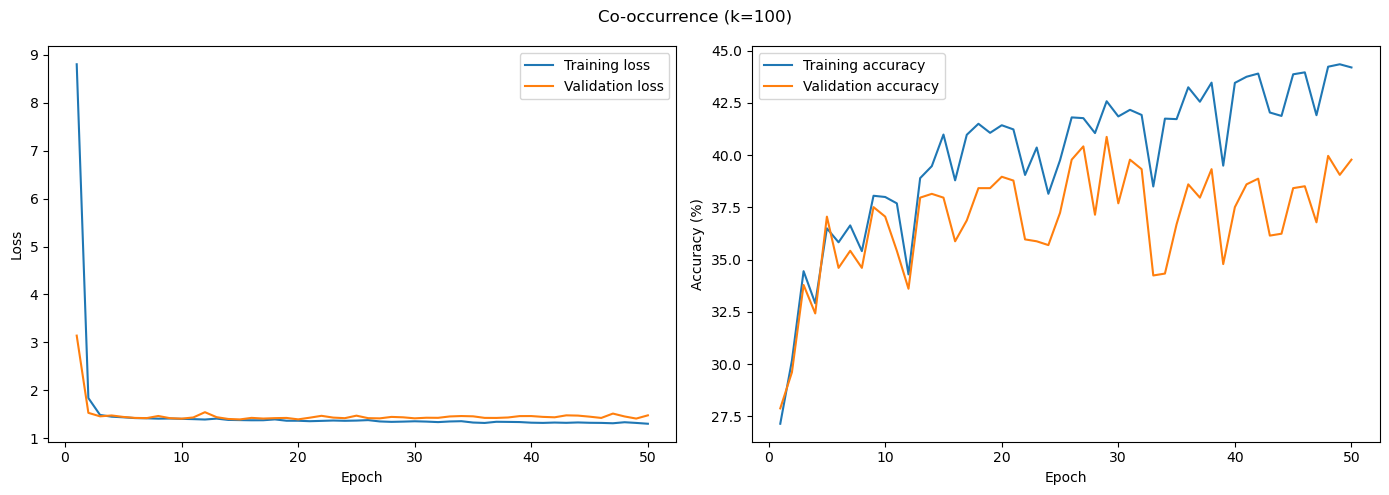

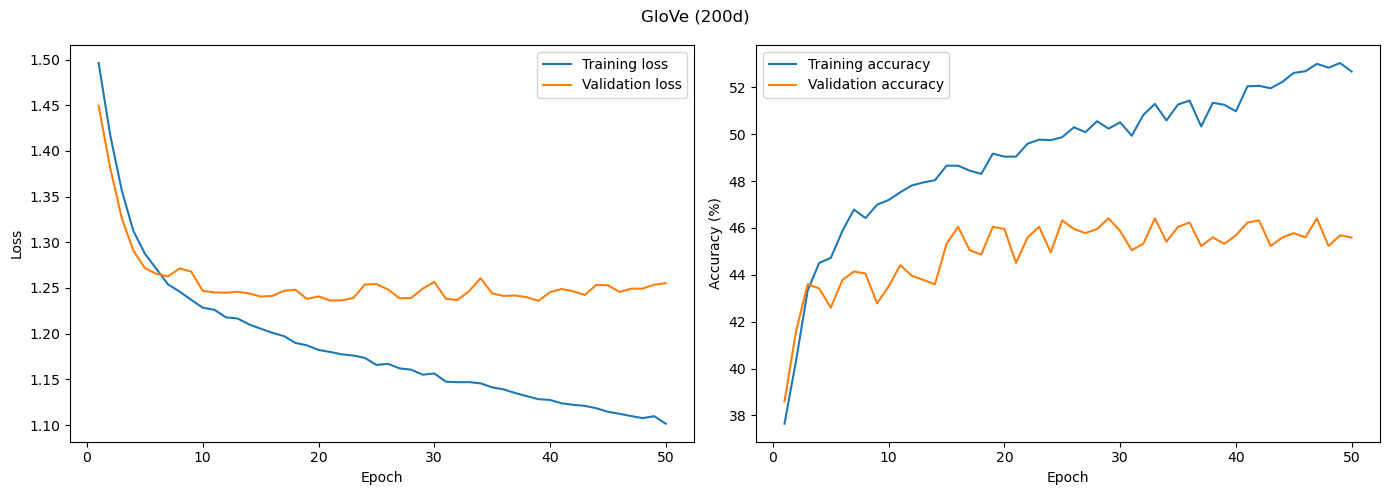

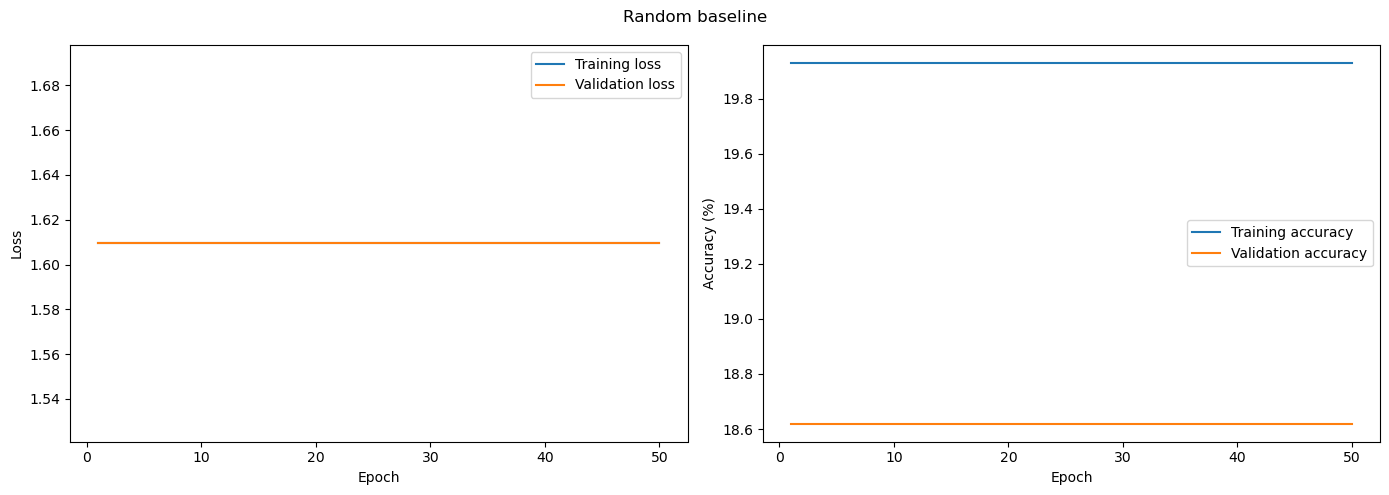

Summary of results:
Co-occurrence (k=100): Train 44.19% | Val 39.78% | Test 37.88%
GloVe (200d): Train 52.68% | Val 45.59% | Test 45.09%
Random baseline: Train 19.93% | Val 18.62% | Test 19.76%


In [65]:
def train_and_evaluate(name, train_pairs, val_pairs, test_pairs, input_dim):
    model = SimpleNN(input_dim, hidden_size, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = build_loader(train_pairs, batch_size=batch_size, shuffle=True)
    val_loader = build_loader(val_pairs, batch_size=batch_size, shuffle=False)
    test_loader = build_loader(test_pairs, batch_size=batch_size, shuffle=False)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        batch_losses = []
        loop = tqdm(train_loader, desc=f"{name} | Epoch {epoch}/{num_epochs}")
        for inputs, targets in loop:
            inputs = inputs.to(device)
            targets = targets.to(device)

            logits = model(inputs)
            loss = criterion(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        mean_train_loss = sum(batch_losses) / len(batch_losses)
        train_losses.append(mean_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                logits = model(inputs)
                total_val_loss += criterion(logits, targets).item()
        mean_val_loss = total_val_loss / len(val_loader)
        val_losses.append(mean_val_loss)

        train_acc = evaluate_accuracy(train_loader, model) * 100
        val_acc = evaluate_accuracy(val_loader, model) * 100
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(
            f"{name} | Epoch [{epoch}/{num_epochs}] "
            f"Train Loss: {mean_train_loss:.3f} | Val Loss: {mean_val_loss:.3f} | "
            f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
        )

    test_accuracy = evaluate_accuracy(test_loader, model) * 100
    return {
        "name": name,
        "model": model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "test_accuracy": test_accuracy,
        "train_accuracy": train_accuracies[-1],
        "val_accuracy": val_accuracies[-1],
    }


def run_random_baseline(train_pairs, val_pairs, test_pairs, num_classes, num_epochs, seed=0):
    rng = np.random.default_rng(seed)

    def random_accuracy(pairs):
        if not pairs:
            return 0.0
        labels = np.array([lbl for _, lbl in pairs])
        preds = rng.integers(0, num_classes, size=len(labels))
        return (preds == labels).mean() * 100

    train_acc = random_accuracy(train_pairs)
    val_acc = random_accuracy(val_pairs)
    test_acc = random_accuracy(test_pairs)

    loss_constant = float(np.log(num_classes))
    constant_losses = [loss_constant] * num_epochs

    return {
        "name": "Random baseline",
        "model": None,
        "train_losses": constant_losses,
        "val_losses": constant_losses,
        "train_accuracies": [train_acc] * num_epochs,
        "val_accuracies": [val_acc] * num_epochs,
        "test_accuracy": test_acc,
        "train_accuracy": train_acc,
        "val_accuracy": val_acc,
    }


results = []
for name, cfg in experiments.items():
    print("" + "=" * 50)
    print(f"Running experiment: {name}")
    print("=" * 50)
    result = train_and_evaluate(name, cfg["train"], cfg["val"], cfg["test"], cfg["input_dim"])
    results.append(result)
    print(f"{name} | Final Test Accuracy: {result['test_accuracy']:.2f}%")

baseline_result = run_random_baseline(
    experiments["Co-occurrence (k=100)"]["train"],
    experiments["Co-occurrence (k=100)"]["val"],
    experiments["Co-occurrence (k=100)"]["test"],
    num_classes=num_classes,
    num_epochs=num_epochs,
)
results.append(baseline_result)
print(f"Random baseline | Test Accuracy: {baseline_result['test_accuracy']:.2f}%")

# Plot loss and accuracy curves for each experiment
for result in results:
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(14, 5))
    plt.suptitle(result["name"])

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, result["train_losses"], label="Training loss")
    plt.plot(epochs_range, result["val_losses"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, result["train_accuracies"], label="Training accuracy")
    plt.plot(epochs_range, result["val_accuracies"], label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

print("Summary of results:")
for result in results:
    print(
        f"{result['name']}: Train {result['train_accuracy']:.2f}% | "
        f"Val {result['val_accuracy']:.2f}% | Test {result['test_accuracy']:.2f}%"    )



### Observations on Network Performance

**Co-occurrence (k=100).** Training and validation curves flatten quickly: accuracy stays roughly in the mid‑30s and the gap between the two curves is small, which matches the summary table above. That suggests the averaged co-occurrence embeddings still provide some discriminative signal beyond a baseline, and the DAN mostly underfits regardless of longer training.

**GloVe (200d).** This run climbs into the high‑50% range on the training split and the mid‑40s on validation/test. Loss keeps trending downward longer, which hints that the richer pretrained vectors let the network learn more nuanced patterns before overfitting.

**Comparison.** GloVe consistently beats the co-occurrence embeddings by roughly 10 accuracy points.


# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
3. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
4. You have two options for the submission. You need to either submit your final .ipynb notebook, or its "pdf" version. Note that in all cases, we expect you to put everything that we asked for (codes, outputs, written answers, visual results etc.) in that single file.
5. A: If you choose to submit a pdf, once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. Make sure all your solutions especially the coding parts are displayed in the pdf, it's okay if the provided codes get cut off and go into the next page because lines are not wrapped in code cells). Look at the PDF file and make sure all your solutions are there, displayed correctly. NOTE: If you have any problems with this way of extracting and downloading the PDF, you are free to use ANY tool to make it work, as long as you are able to provide a usual PDF with all the requirements formatted nicely in it.
5. B: If you choose to submit the notebook itself, download a .ipynb version of your notebook while making sure that its all-comprehensive and self-contained.
6. Please name your files as username_assignment1.ipynb or username_assignment1.pdf.
7. Submit your work to Learnhub by the deadline.

*This assignment is adapted from Stanford [CS224n](http://web.stanford.edu/class/cs224n/)*